In [2]:
!pip install opendatasets --upgrade --quiet


In [3]:
!pip install utils

In [4]:
import random
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import glob


In [5]:
# get the data from
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation'
od.download(dataset_url)


Skipping, found downloaded files in "./lgg-mri-segmentation" (use force=True to force download)


In [6]:
# setting size parameters of images
im_width = 256
im_height = 256

###Loading the image and mask paths


In [7]:
from glob import glob

image_filenames_train = []

# creating a list of all files containing the word 'mask'
mask_files = glob('/content/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
  image_filenames_train.append(i.replace('_mask', ''))

print(image_filenames_train[:10])
len(image_filenames_train)


['/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_16.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_20.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_26.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_15.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_33.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_17.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_31.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_10.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_28.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_11.tif']


3929

In [8]:
def plot_from_img_path(rows, columns, list_img_path, list_mask_path):
   fig = plt.figure(figsize = (12, 12))
   for i in range(1, rows * columns + 1):
     fig.add_subplot(rows, columns, i)
     img_path = list_img_path[i]
     mask_path = list_mask_path[i]
     image = cv2.imread(img_path)
     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
     mask = cv2.imread(mask_path)
     plt.imshow(image)
     plt.imshow(mask, alpha=0.4)
   plt.show()



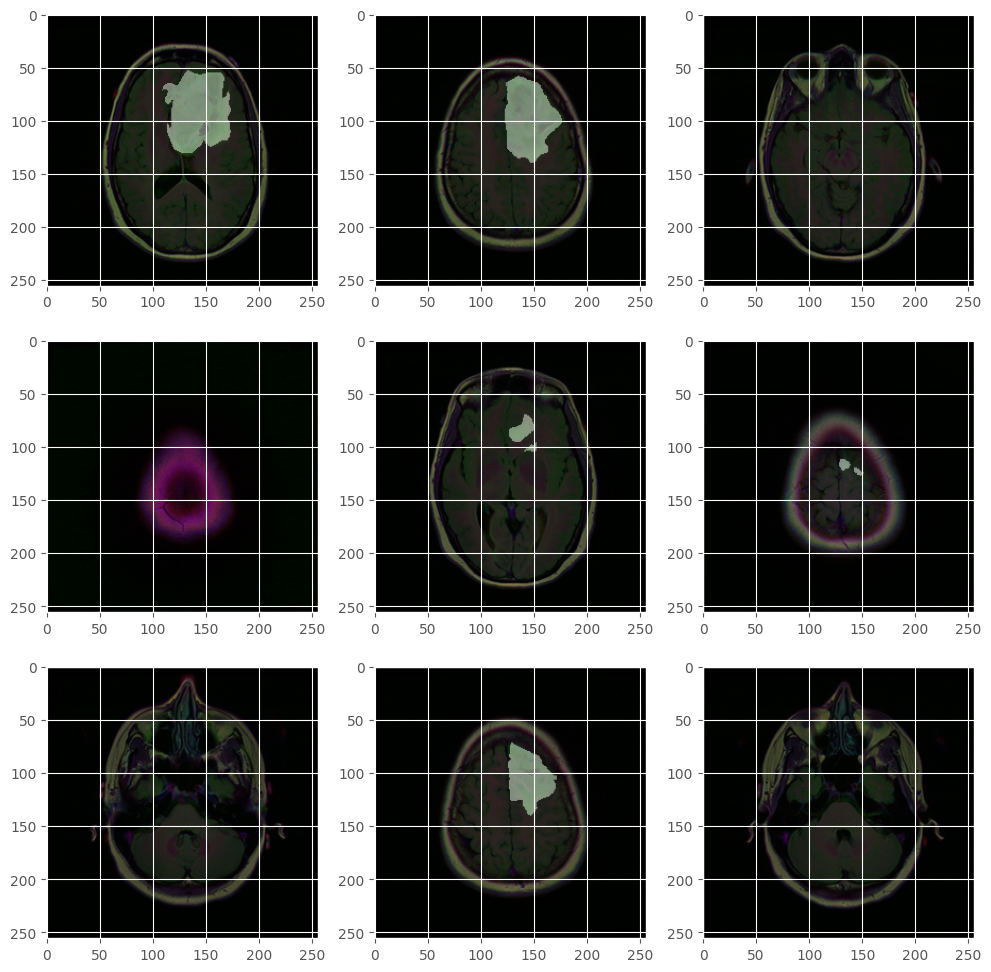

In [9]:
plot_from_img_path(3, 3, image_filenames_train, mask_files)

In [10]:
def dice_coefficients(y_true, y_pred, smooth=100):
   y_true_flatten = K.flatten(y_true)
   y_pred_flatten = K.flatten(y_pred)

   intersection = K.sum(y_true_flatten * y_pred_flatten)
   union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
   return (2 * intersection + smooth) / (union + smooth)



def dice_coefficients_loss(y_true, y_pred, smooth=100):
   return -dice_coefficients(y_true, y_pred,smooth)



def iou(y_true, y_pred, smooth=100):
  intersection = K.sum(y_true * y_pred)
  sum = K.sum(y_true + y_pred)
  iou = (intersection+ smooth)/ (sum - intersection + smooth)
  return iou




def Jaccard_distance(y_true, y_pred):
   y_true_flatten = K.flatten(y_true)
   y_pred_flatten = K.flatten(y_pred)
   return -iou[y_true_flatten, y_pred_flatten]



#model.compile(optimizer=opt, loss=dice_coefficients_loss, metrics=["binary_accuracy", iou, dice_coefficients])



In [11]:
df = pd.DataFrame(data={'image_filenames_train': image_filenames_train, 'mask': mask_files})

df_train, df_test = train_test_split(df, test_size=0.1)

# further split this val and train
df_train, df_val = train_test_split(df_train, test_size=0.2)


print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

(2828, 2)
(393, 2)
(708, 2)


In [12]:
df.head()

,image_filenames_train,mask
0,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...
1,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...
2,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...
3,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...
4,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...


In [13]:
def trainGenerator(dataframe, batch_size, aug_dict, image_color_mode="grayscale",
                   mask_color_mode="grayscale", image_save_prefix="image", mask_save_prefix="mask",
                   save_to_dir=None, target_size=(256, 256), seed=1):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_dataframe(
        dataframe,
        x_col="image_filenames_train",
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed)
    mask_generator = mask_datagen.flow_from_dataframe(
        dataframe,
        x_col="mask",
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed)

    for (img, mask) in zip(image_generator, mask_generator):
        img, mask = normalize_and_diagnose(img, mask)
        yield (img, mask)


In [14]:
### After mask normalization if te value is <= 0.5 then that mask
### will e considered a complete black one and does not have any tumor...

def normalize_and_diagnose(img, mask):
  img = img / 255
  mask = mask / 255
  mask[mask > 0.5] = 1
  mask[mask <= 0.5] = 0
  return (img, mask)




###UNet architecture
decoder
u6 = u6 + c4
u7 = u7 + c3
u8 = u8 + c2
u9 = u9 + c1



In [15]:
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import (
    Input,
    Activation,
    BatchNormalization,
    Dropout,
    Lambda,
    Conv2D,
    Conv2DTranspose,
    MaxPooling2D,
    concatenate,
)
from tensorflow.keras import backend as K


def unet(input_size=(256, 256, 3)):
    """
    This function creates and returns a U-Net model. U-Net is a type of convolutional neural network
    designed for fast and precise segmentation of images. It consists of a contracting (downsampling)
    path and an expansive (upsampling) path, which gives it a U-shaped architecture.

    Parameters:
    -----------
    input_size : tuple of int
        The size of the input images. It is a 3-tuple for (height, width, channels).
        Default is (256, 256, 3).

    Returns:
    --------
    model : keras.models.Model
        The constructed U-Net model.
    """
    inputs = Input(input_size)

    # First DownConvolution / Encoder Leg will begin, so start with Conv2D
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(inputs)
    bn1 = Activation("relu")(conv1)
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation("relu")(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(pool1)
    bn2 = Activation("relu")(conv2)
    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation("relu")(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(pool2)
    bn3 = Activation("relu")(conv3)
    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation("relu")(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(pool3)
    bn4 = Activation("relu")(conv4)
    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation("relu")(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(pool4)
    bn5 = Activation("relu")(conv5)
    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation("relu")(bn5)

    """ Now UpConvolution / Decoder Leg will begin, so start with Conv2DTranspose
    The gray arrows (in the above image) indicate the skip connections that concatenate the encoder feature map with the decoder, which helps the backward flow of gradients for improved training. """
    up6 = concatenate(
        [
            Conv2DTranspose(512, kernel_size=(2, 2), strides=(2, 2), padding="same")(
                bn5
            ),
            conv4,
        ],
        axis=3,
    )
    """ After every concatenation we again apply two consecutive regular convolutions so that the model can learn to assemble a more precise output """
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(up6)
    bn6 = Activation("relu")(conv6)
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation("relu")(bn6)

    up7 = concatenate(
        [
            Conv2DTranspose(256, kernel_size=(2, 2), strides=(2, 2), padding="same")(
                bn6
            ),
            conv3,
        ],
        axis=3,
    )
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(up7)
    bn7 = Activation("relu")(conv7)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation("relu")(bn7)

    up8 = concatenate(
        [
            Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), padding="same")(
                bn7
            ),
            conv2,
        ],
        axis=3,
    )
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(up8)
    bn8 = Activation("relu")(conv8)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation("relu")(bn8)

    up9 = concatenate(
        [
            Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding="same")(
                bn8
            ),
            conv1,
        ],
        axis=3,
    )
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(up9)
    bn9 = Activation("relu")(conv9)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation("relu")(bn9)

    conv10 = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

In [17]:
EPOCHS = 50
BATCH_SIZE = 32
learning_rate = 1e-4
smooth = 100

In [18]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler




In [19]:

train_generator_param = dict(rotation_range=0.2, width_shift_range=0.05, shear_range=0.05, zoom_range=0.05, horizontal_flip=True ,fill_mode='nearest')

train_gen = trainGenerator(df_train, BATCH_SIZE, train_generator_param, target_size=(im_height, im_width))

test_gen = trainGenerator(df_test,BATCH_SIZE, dict(), target_size=(im_height, im_width))

model = unet(input_size=(im_height, im_width,1))

decay_rate = learning_rate / EPOCHS

opt = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-7, amsgrad=False)


model.compile(optimizer=opt, loss=dice_coefficients_loss, metrics=['binary_accuracy', iou, dice_coefficients])

callbacks = [ModelCheckpoint('unet.hdf5', verbose=1, save_beat_only=True)]



In [20]:
history = model.fit (train_gen,
                     steps_per_epoch=len(df_train)/BATCH_SIZE,
                     epochs=EPOCHS, callbacks=callbacks,
                     validation_data=test_gen,
                     validation_steps=len(df_test)/BATCH_SIZE)

Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/50
89/88 [==============================] - ETA: -1s - loss: -0.0743 - binary_accuracy: 0.8451 - iou: 0.0392 - dice_coefficients: 0.0748Found 393 validated image filenames.
Found 393 validated image filenames.

Epoch 1: saving model to unet.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


88/88 [==============================] - 237s 2s/step - loss: -0.0743 - binary_accuracy: 0.8451 - iou: 0.0392 - dice_coefficients: 0.0748 - val_loss: -0.0228 - val_binary_accuracy: 0.9887 - val_iou: 0.0118 - val_dice_coefficients: 0.0232
Epoch 2/50
89/88 [==============================] - ETA: 0s - loss: -0.1050 - binary_accuracy: 0.9373 - iou: 0.0560 - dice_coefficients: 0.1053
Epoch 2: saving model to unet.hdf5
88/88 [==============================] - 157s 2s/step - loss: -0.1050 - binary_accuracy: 0.9373 - iou: 0.0560 - dice_coefficients: 0.1053 - val_loss: -0.0227 - val_binary_accuracy: 0.9888 - val_iou: 0.0115 - val_dice_coefficients: 0.0224
Epoch 3/50
89/88 [==============================] - ETA: 0s - loss: -0.1348 - binary_accuracy: 0.9623 - iou: 0.0734 - dice_coefficients: 0.1354
Epoch 3: saving model to unet.hdf5
88/88 [==============================] - 157s 2s/step - loss: -0.1348 - binary_accuracy: 0.9623 - iou: 0.0734 - dice_coefficients: 0.1354 - val_loss: -0.0216 - val_bi

In [24]:
import pprint
pprint.pprint(history.history)

{'binary_accuracy': [0.8451218605041504,
                     0.9373055696487427,
                     0.9622962474822998,
                     0.9786732792854309,
                     0.9798233509063721,
                     0.9874668121337891,
                     0.9904933571815491,
                     0.9923731088638306,
                     0.9934114217758179,
                     0.9941092729568481,
                     0.9938884377479553,
                     0.9945716857910156,
                     0.9953088164329529,
                     0.9955868124961853,
                     0.9956152439117432,
                     0.9961262941360474,
                     0.9961224794387817,
                     0.9964276552200317,
                     0.996370255947113,
                     0.9962982535362244,
                     0.9966148138046265,
                     0.9962666630744934,
                     0.9968346953392029,
                     0.9966632723808289,
                 

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


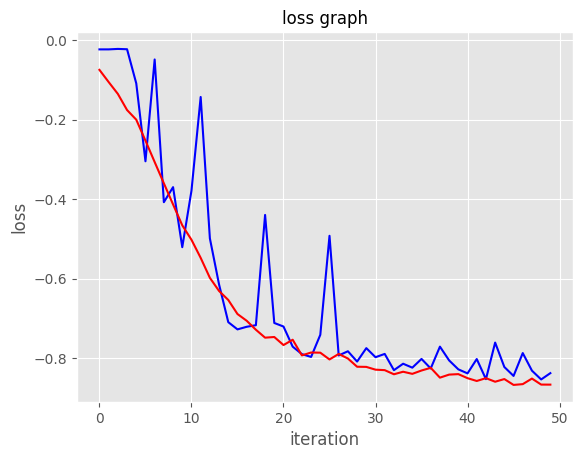

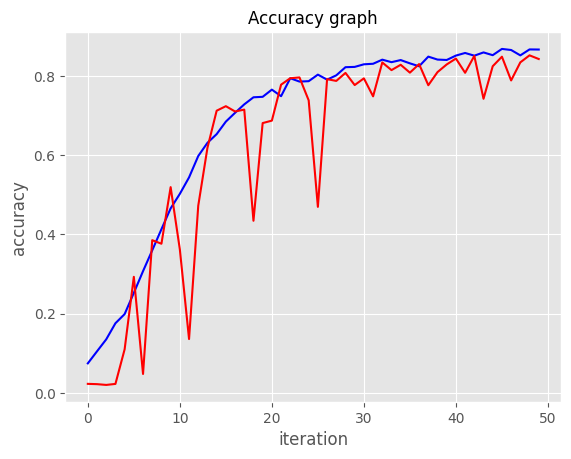

In [26]:
history_post_training = history.history

train_dice_coeff = history_post_training['dice_coefficients']
list_test_dice_coeff = history_post_training['val_dice_coefficients']

train_jaccard_list = history_post_training['iou']
test_jaccard_list = history_post_training['val_iou']

train_loss_list = history_post_training['loss']
test_loss_list = history_post_training['val_loss']

plt.figure(1)
plt.plot(test_loss_list, 'b-')
plt.plot(train_loss_list, 'r-')

plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 12)

plt.figure(2)
plt.plot(train_dice_coeff, 'b-')
plt.plot(list_test_dice_coeff, 'r-')

plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('Accuracy graph', fontsize = 12)
plt.show()








#Load the model

In [31]:
# Load the model with custom objects registered
model = load_model('/content/drive/MyDrive/Data/unet.hdf5', custom_objects={
    'dice_coefficients_loss': dice_coefficients_loss,
    'iou': iou,
    'dice_coefficients': dice_coefficients
})

In [32]:
test_gen = trainGenerator(df_test, BATCH_SIZE,dict(), target_size=(im_height,im_width))
results = model.evaluate(test_gen,steps=len(df_test)/ BATCH_SIZE)

print( 'Test_loss', results[0] )
print('Test_IoU', results[1])
print('Test Dice Coefficient' , results[2])

Found 393 validated image filenames.
Found 393 validated image filenames.
12/12 [==============================] - 6s 482ms/step - loss: -0.8062 - binary_accuracy: 0.9968 - iou: 0.6776 - dice_coefficients: 0.8034
Test_loss -0.8061962127685547
Test_IoU 0.9967597126960754
Test Dice Coefficient 0.6775776147842407


##Plotting Predicted Masks Segmentation results from the Test Image set

image_shape (1, 256, 256, 1)
1/1 [==============================] - 0s 21ms/step


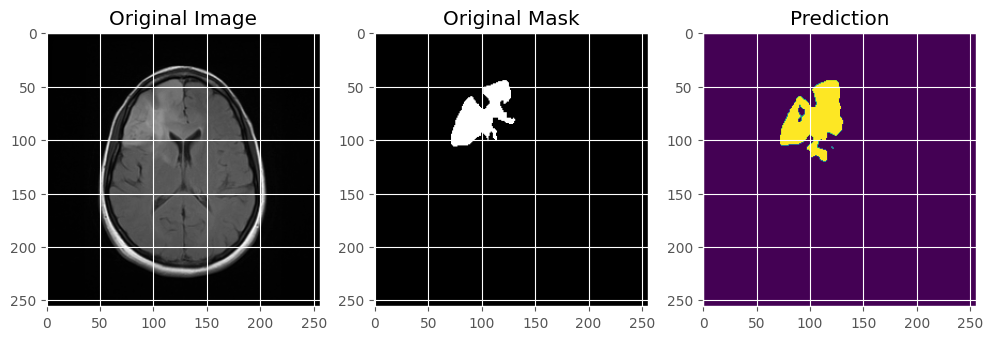

image_shape (1, 256, 256, 1)
1/1 [==============================] - 0s 19ms/step


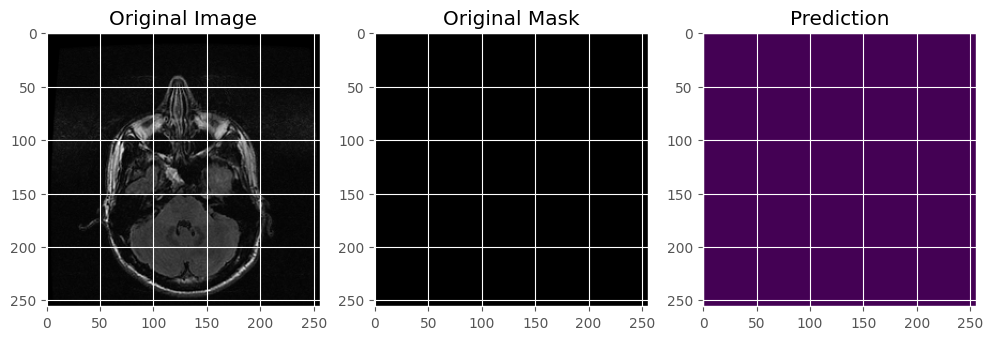

image_shape (1, 256, 256, 1)
1/1 [==============================] - 0s 25ms/step


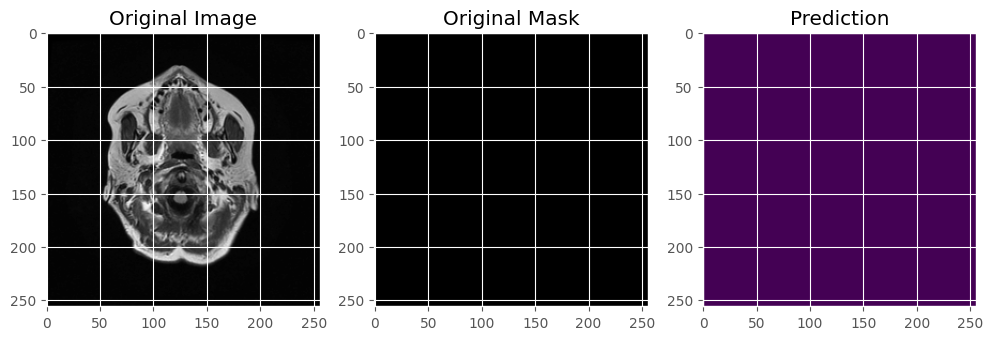

image_shape (1, 256, 256, 1)
1/1 [==============================] - 0s 22ms/step


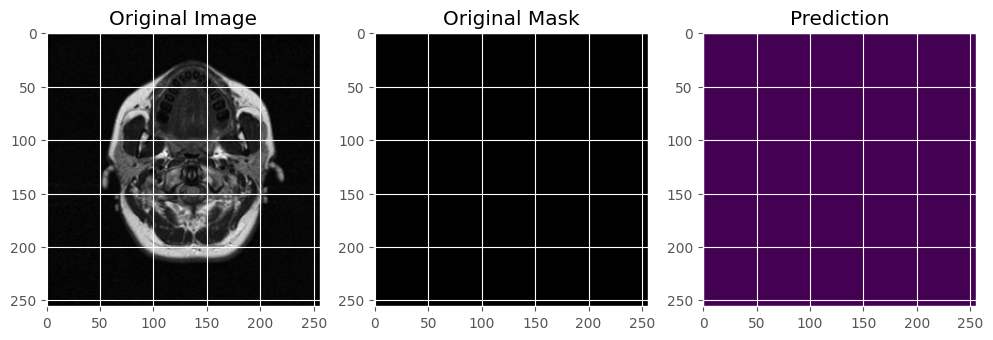

image_shape (1, 256, 256, 1)
1/1 [==============================] - 0s 22ms/step


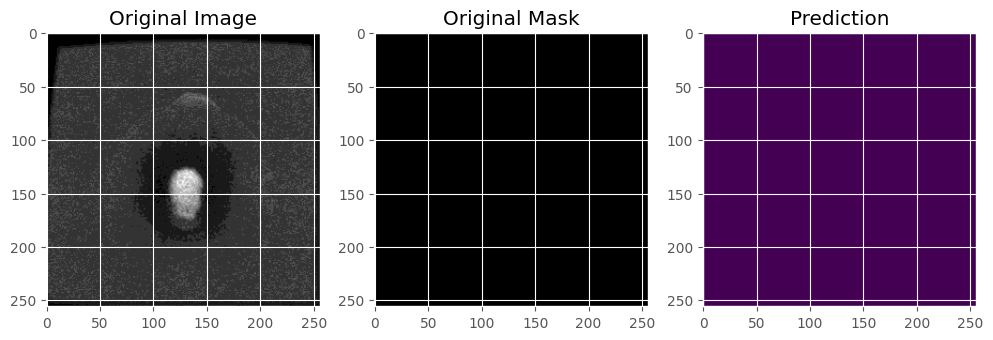

In [33]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

for i in range(5):
    index = np.random.randint(0, len(df_test.index))
    img = cv2.imread(df_test['image_filenames_train'].iloc[index])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    img = cv2.resize(img, (im_height, im_width))
    img = img / 255
    img = img[np.newaxis, :, :, np.newaxis]  # Add the extra dimension for channels
    print("image_shape",img.shape)
    predicted_img = model.predict(img)

    plt.figure(figsize=(12, 12))
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img), cmap='gray')  # Show as grayscale
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(predicted_img) > 0.5)
    plt.title('Prediction')
    plt.show()
